# MonReader

This project develops a machine learning model for classification tasks in the field of computer vision. In the notebook, a three-layer CNN model is trained on the low-resolution images of a book from the mobile. The trained model extracts the relevant features and patterns from the low-resolution image and classifies them as 'flip' and 'not flip'.

Let's start with a small description of the relevance of this project to an industrial application. MonReader is a new mobile document digitization experience for the blind, researchers, and everyone else needing fully automatic, high-speed, and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages MonReader handles everything: it detects page flips from a low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

Here, I am focusing on the first step of the MonReader process, i.e. detecting a page flip from low-resolution images, which triggers subsequent steps from capturing high-resolution images to reading text. The contents of this notebook are as follows:
- 1. Extract Images
- 2. Data Preprocessing
- 3. CNN model
- 4. Model training
- 5. Results

## 1. Extract Images

In this section, I have created a function `get_data`, which looks extract all the images inside a directory. The images files of available data set has following structure:
- images
    - testing
        - flip
        - notflip
    - training
        - flip
        - notflip

Import the necessary libraries to change directories, read data, and plot results.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

The `get_data` function read images file using `cv2.imread` function, convert it RGB format, and reshape images to required size. 

In [2]:
labels = ['flip', 'notflip']
img_size = 224
def get_data(data_dir):
    data_x, data_y = [] , []
    for label in labels: 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data_x.append(resized_arr)
                data_y.append(labels.index(label))
            except Exception as e:
                print(e)
    return np.array(data_x), np.array(data_y)

The images inside training and testing directories are read separately and store in 'train' and 'test' variables, respectively.

In [3]:
x_train, y_train = get_data(os.path.join(os.getcwd(), 'images/training'))
x_test, y_test = get_data(os.path.join(os.getcwd(), 'images/testing'))

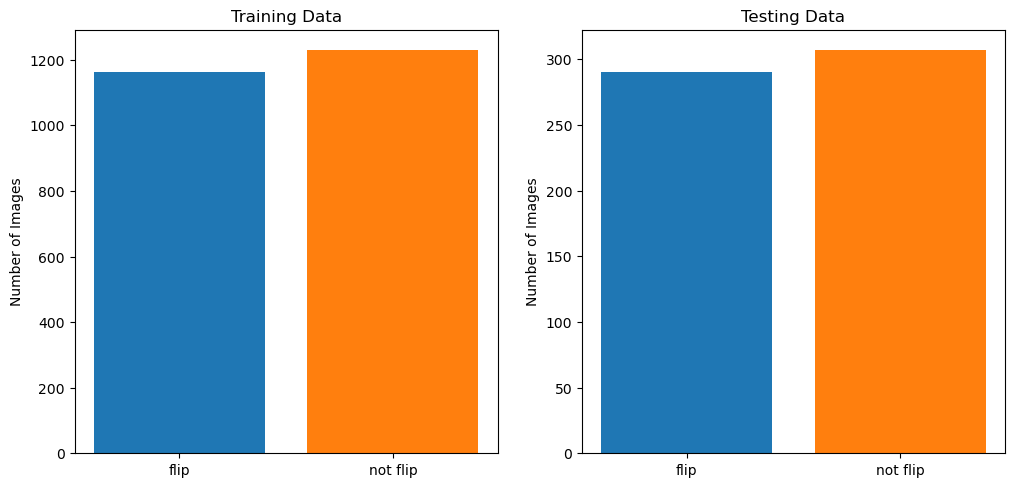

In [4]:
train_count1, test_count1 = sum(y_train), sum(y_test)
train_count0, test_count0 = len(y_train) - train_count1, len(y_test) - test_count1

fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))
axes[0].bar(['flip', 'not flip'], [train_count0, train_count1], color=['C0', 'C1'])
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Training Data')
axes[1].bar(['flip', 'not flip'], [test_count0, test_count1], color=['C0', 'C1'])
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Testing Data')
plt.show()

In [5]:
print('Total number of images in training set: {}'.format(train_count0+train_count1))
print('Total number of images in training set: {}'.format(test_count0+test_count1))
print('The train to test ratio is {:1.2f}'.format((train_count0+train_count1)/(test_count0+test_count1)))

Total number of images in training set: 2392
Total number of images in training set: 597
The train to test ratio is 4.01


The plot shows that there are no imbalances in the data set and techniques such as SMOTE (Synthetic Minority Sampling Technique) and Balanced Bagged Classifier are not required for this problem.

Here, is an example of images in the data set. The images are not clear due to low resolution, thus these can't be used to read the text but the main idea is to detect the page-flipping and then capture high-resolution images.

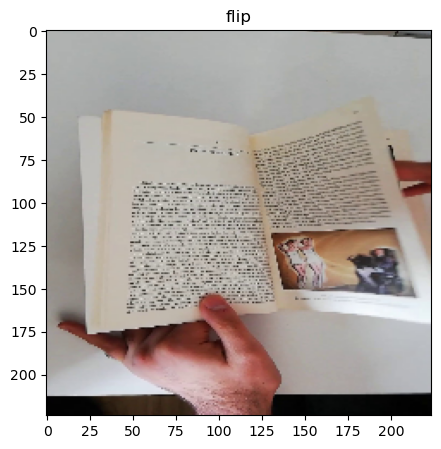

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(x_train[1, :, :, :])
plt.title(labels[y_train[1]])
plt.show()

## 2. Data Preprocessing

Normalize the input data to project picture pixels to a range between 0 to 1. This results in similar data distribution, which allows for faster convergence while the network is being trained.

In [31]:
x_train.reshape(-1, img_size, img_size, 1)
x_train = x_train/255


x_test.reshape(-1, img_size, img_size, 1)
x_test = x_test/255

## 3. CNN model 

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Define a three layer CNN model with alternate max-pooling layer. A dropout layer is added after the 3rd maxpool operation to avoid overfitting.

In [9]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

## 4. Model training

Trained the model using adam optimization algorithm and categorical cross entropy loss function for 100 epochs. 

In [10]:
optimizer = Adam()
model.compile(optimizer=optimizer , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics=['accuracy'])

In [11]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


2024-01-19 09:30:04.379792: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


75/75 [==============================] - 29s 379ms/step - loss: 0.6674 - accuracy: 0.6116 - val_loss: 0.4980 - val_accuracy: 0.7035
Epoch 2/100
75/75 [==============================] - 28s 377ms/step - loss: 0.2733 - accuracy: 0.8804 - val_loss: 0.2025 - val_accuracy: 0.9246
Epoch 3/100
75/75 [==============================] - 30s 400ms/step - loss: 0.1424 - accuracy: 0.9423 - val_loss: 0.2071 - val_accuracy: 0.9028
Epoch 4/100
75/75 [==============================] - 32s 423ms/step - loss: 0.0790 - accuracy: 0.9695 - val_loss: 0.0409 - val_accuracy: 0.9866
Epoch 5/100
75/75 [==============================] - 32s 423ms/step - loss: 0.0343 - accuracy: 0.9900 - val_loss: 0.0385 - val_accuracy: 0.9916
Epoch 6/100
75/75 [==============================] - 33s 439ms/step - loss: 0.0473 - accuracy: 0.9812 - val_loss: 0.1239 - val_accuracy: 0.9497
Epoch 7/100
75/75 [==============================] - 27s 363ms/step - loss: 0.0534 - accuracy: 0.9812 - val_loss: 0.0351 - val_accuracy: 0.9933
Epoc

## 5. Results

This section illustrate the convergence of accuracy and loss function of the model for training and testing data. 

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [30]:
print('Accuracy of CNN model on Training data: {:1.4f}%'.format(acc[-1]*100))
print('Accuracy of CNN model on Testng data: {:1.4f}%'.format(val_acc[-1]*100))

Accuracy of CNN model on Training data: 99.7910%
Accuracy of CNN model on Testng data: 99.4975%


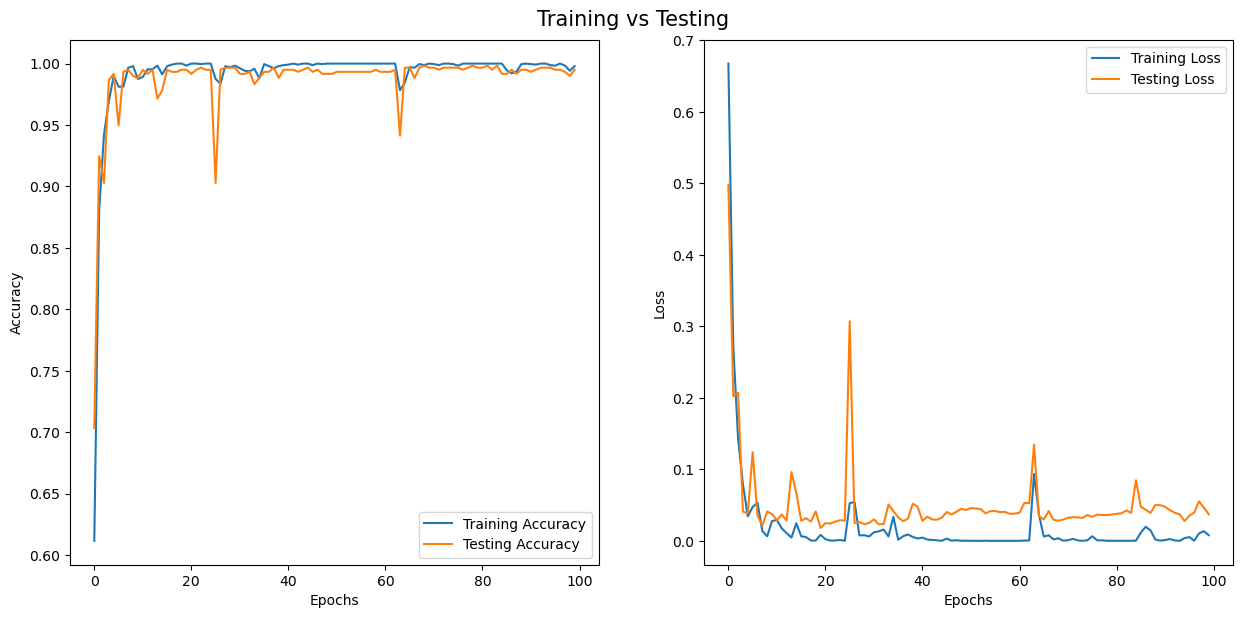

In [24]:
epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.suptitle('Training vs Testing', y=0.9, fontsize=15)
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Lets compute the Confusion matrix using functions provided by the `sklearn` library.

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [26]:
preds = [0 if x[0]>x[1] else 1 for x in model.predict(x_test)]

conf_matrix = confusion_matrix(y_test, preds)

19/19 [==============================] - 3s 123ms/step


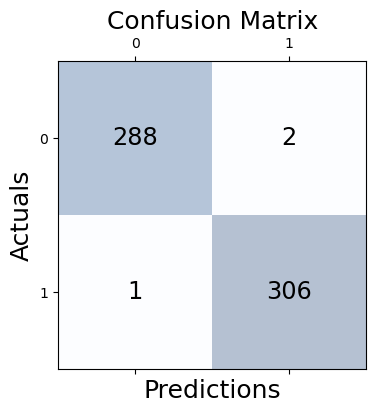

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [29]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       290
           1       0.99      1.00      1.00       307

    accuracy                           0.99       597
   macro avg       1.00      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597

